# Vision Transformer

## Imports

In [1]:
# Imports

# System Imports
import os
import time

# Data Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import helper_functions as hf
import tensorflow as tf

from transformers import ViTFeatureExtractor, TFViTForImageClassification, create_optimizer
import datasets

tf.keras.backend.set_image_data_format('channels_first')

In [2]:
for device in tf.config.list_physical_devices('GPU'):
    print(f"* {device}")

* PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Reading in Data

In [3]:
# Setting paths

train_data_path = './data/archive/train'
test_data_path = './data/archive/test'

In [4]:
# Viewing categories

categories = os.listdir(train_data_path)
print(f"The categories are: {categories}")

The categories are: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [5]:
# Configurations

SEED = 0
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.20
EPOCHS = 10

In [6]:
def create_image_folder_dataset(root_path):
    """creates `Dataset` from image folder structure"""

    # get class names by folders names
    _CLASS_NAMES= os.listdir(root_path)
    
    # defines `datasets` features`
    features = datasets.Features({
        "img": datasets.Image(),
        "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
    })
    
    # temp list holding datapoints for creation
    img_data_files=[]
    label_data_files=[]
    
    # load images into list for creation
    for img_class in os.listdir(root_path):
        for img in os.listdir(os.path.join(root_path,img_class)):
            path_= os.path.join(root_path, img_class,img)
            img_data_files.append(path_)
            label_data_files.append(img_class)
    
    # create dataset
    ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
    return ds

In [7]:
df = create_image_folder_dataset("./data/archive/train")
df

Dataset({
    features: ['img', 'label'],
    num_rows: 2746
})

In [8]:
img_class_labels = df.features["label"].names
img_class_labels

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

In [9]:
model_path = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

In [10]:
# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

In [11]:
df_processed = df.map(process, batched=True)
df_processed

  0%|          | 0/3 [00:00<?, ?ba/s]

Dataset({
    features: ['img', 'label', 'pixel_values'],
    num_rows: 2746
})

In [12]:
# test size will be 20% of train dataset
test_size=.2

df_processed = df_processed.shuffle().train_test_split(test_size=test_size)
df_processed

DatasetDict({
    train: Dataset({
        features: ['img', 'label', 'pixel_values'],
        num_rows: 2196
    })
    test: Dataset({
        features: ['img', 'label', 'pixel_values'],
        num_rows: 550
    })
})

In [13]:
id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_path.split("/")[1]
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
# if fp16:
#   tf.keras.mixed_precision.set_global_policy("mixed_float16")


In [14]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
train = df_processed["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
validation = df_processed["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

2023-01-26 22:02:42.594494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-26 22:02:42.595212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [15]:
# create optimizer wight weigh decay
num_train_steps = len(train) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
vit_model = TFViTForImageClassification.from_pretrained(
    model_path,
#     num_labels=len(img_class_labels),
#     id2label=id2label,
#     label2id=label2id,
    ignore_mismatched_sizes=True
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,224,224)),
    vit_model.layers[0],
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5)
])

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [16]:
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  85798656  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=None, hid            
                             den_states=None, attenti            
                             ons=None)                           
                                                                 
 flatten (Flatten)           (None, 151296)            0         
                                                                 
 dense (Dense)               (None, 5)                 756485    
                                                                 
Total params: 86,555,141
Trainable params: 86,555,141
Non-trainable params: 0
____________________________________________

In [18]:
tf.keras.backend.clear_session()
start_time = time.time()
history = model.fit(
    train,
    validation_data=validation,
    callbacks=callbacks,
    epochs=3,
)
elapsed_time = time.time() - start_time

Epoch 1/3


2023-01-26 22:09:01.973080: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-26 22:09:08.291269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9403 - top-3-accuracy: 0.9882 

2023-01-26 22:26:24.873988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 1179s 17s/step - loss: 0.1860 - accuracy: 0.9403 - top-3-accuracy: 0.9882 - val_loss: 0.0956 - val_accuracy: 0.9673 - val_top-3-accuracy: 1.0000
Epoch 2/3
69/69 [==============================] - 1140s 16s/step - loss: 0.2262 - accuracy: 0.9800 - top-3-accuracy: 0.9923 - val_loss: 0.0776 - val_accuracy: 0.9745 - val_top-3-accuracy: 1.0000
Epoch 3/3
69/69 [==============================] - 1398s 20s/step - loss: 0.1873 - accuracy: 0.9804 - top-3-accuracy: 0.9950 - val_loss: 0.0753 - val_accuracy: 0.9691 - val_top-3-accuracy: 1.0000


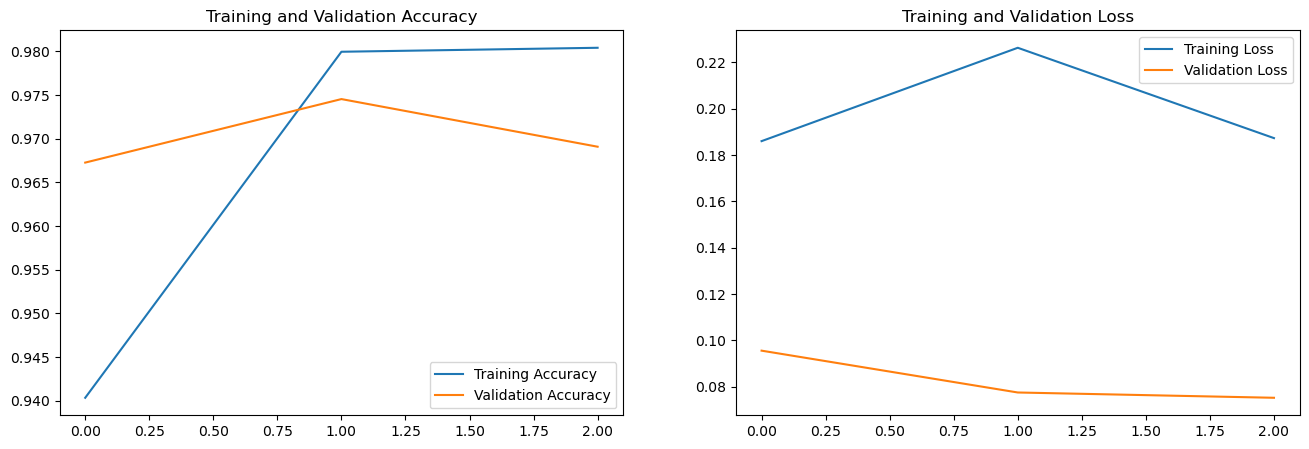

In [19]:
hf.plot_history(history, epochs=3)

In [20]:
model.save("./saved_model/tf-vit")

INFO:tensorflow:Assets written to: ./saved_model/tf-vit/assets


INFO:tensorflow:Assets written to: ./saved_model/tf-vit/assets


## Uploading Model to HuggingFace Hub

In [44]:
from huggingface_hub import notebook_login

In [45]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/tqrahman/.huggingface/token
Login successful


In [46]:
model.push_to_hub("taraqur/blossom-vit")

In [49]:
blossom_model_path = 'taraqur/blossom-vit'
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)
# blossom_feature_extractor = ViTFeatureExtractor.from_pretrained(blossom_model_path)
blossom_model= TFViTForImageClassification.from_pretrained(blossom_model_path)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at taraqur/blossom-vit.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [50]:
blossom_model.predict(input_tf_image)

2022-12-12 23:04:02.431545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step


TFSequenceClassifierOutput(loss=None, logits=array([[-1.8736795 ,  5.0176973 , -0.43274173, -1.3334539 , -2.1839182 ]],
      dtype=float32), hidden_states=None, attentions=None)

## New Image

In [ ]:
# new_image = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)

In [25]:
new_image_path = './data/FREEDOM.jpg'

In [59]:
from PIL import Image

image = Image.open(new_image_path)

In [53]:
# Creating a dataset object with the new image

features = datasets.Features({
    "img": datasets.Image(),
    "label": datasets.features.ClassLabel(names=df.features["label"].names),
})

input_image = datasets.Dataset.from_dict({"img":[new_image_path],"label":["rose"]}, features=features)

In [54]:
# Preprocessing the image

input_processed = input_image.map(process, batched=True)
input_processed

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['img', 'label', 'pixel_values'],
    num_rows: 1
})

In [32]:
# Converting the image to tf dataset

input_tf_image = input_processed.to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   batch_size=1,
   collate_fn=data_collator
)

In [61]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
inputs = image_processor(image, return_tensors="tf")
# model.predict(inputs)

In [66]:
logits = model(**inputs).logits

In [67]:
logits

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-1.8736795 ,  5.0176973 , -0.43274206, -1.3334533 , -2.1839182 ]],
      dtype=float32)>

In [36]:
# Predicting on the new image

pred = model.predict(input_tf_image)

1/1 [==============================] - 1s 1s/step


In [39]:
# Indexing the prediction on the labels

class_labels[np.argmax(np.exp(pred.logits)/np.sum(np.exp(pred.logits)))]

1

In [ ]:
# # Creating the training set

# training_set = tf.keras.preprocessing.image_dataset_from_directory(
#     train_data_path,
#     validation_split=VALIDATION_SPLIT,
#     subset="training",
#     seed=SEED,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode="categorical",
#     class_names=categories
# )

In [ ]:
# # Creating the validation set

# validation_set = tf.keras.preprocessing.image_dataset_from_directory(
#     train_data_path,
#     validation_split=VALIDATION_SPLIT,
#     subset="validation",
#     seed=SEED,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode="categorical",
#     class_names=categories
# )

## Modeling

In [ ]:
# model = TFViTForImageClassification.from_pretrained(model_path)
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)
# # feature_extractor

### Data Preprocessing

In [ ]:
# # Changing channel axis to the first dimension

# train = training_set.map(lambda x, y: (tf.experimental.numpy.moveaxis(x, -1, 1), y)) 
# valid = validation_set.map(lambda x, y: (tf.experimental.numpy.moveaxis(x, -1, 1), y)) 

In [ ]:
# def preprocess_images(examples):

#     print(examples.shape)
#     images = examples['img']
#     images = [np.array(image, dtype=np.uint8) for image in images]
#     # images = [np.moveaxis(image, source=-1, destination=0) for image in images]
#     inputs = feature_extractor(images=images)
#     examples['pixel_values'] = inputs['pixel_values']

#     return examples.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# def process_example(image, label):
#     inputs = feature_extractor(image.numpy(), return_tensors='tf')
#     print(inputs)
#     inputs['labels'] = label
#     return inputs

# def transform(example_batch):
#     # Take a list of PIL images and turn them to pixel values
#     inputs = feature_extractor([x for x in example_batch[0]], return_tensors='tf')

#     # Don't forget to include the labels!
#     inputs['labels'] = example_batch[1]
#     return inputs

In [ ]:
# train = train.map(process_example) 
# valid = valid.map(process_example) 

# # results = []
# # for image,label in temp_set.take(1):
# #     results.append(process_example([image, label]))
# #     # print(tf.shape(data[1]))
# #     break

In [ ]:
# # inputs
# pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

# # model layer
# vit = model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(vit[:, 0, :])

# # model
# keras_model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

In [ ]:
# tf.keras.backend.clear_session()

# start_time = time.time()

# ## Compiling the model
# keras_model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# vit_history = keras_model.fit(
#   training_set,
#   validation_data=validation_set,
#   epochs=EPOCHS
# )

# elasped_time = time.time() - start_time
# # model_elapsed_time["vit"] = elasped_time